## Models

Now, we have to train a model. Here, we have to predict two target: *AccumulationInvestment* and *IncomeInvestment*. We chose, for each types of algorithms, to implement one model by target. In this part, we will try to implement all the algorithms that we saw during the class lectures. Then, we will test there performance and choose the best one.  
  
To start, we import our previous data.

In [1]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


In [3]:
#Load our datas

%store -r X_inc
%store -r X_acc
%store -r t_inc
%store -r t_acc

In [17]:
#Create the subsets Train (85 %) and Test (15 %)
from sklearn.model_selection import train_test_split

XInc_train, XInc_test, XAcc_train, XAcc_test,  Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X_inc, X_acc, t_inc, t_acc, test_size=0.15, shuffle=True, random_state=5)

In [ ]:
#Importation of the model libraries
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

### Logistic models
  
The first models are the Logistic model. The principe of a Logistic regression is to classify observations into two class: "positive outcome" *C1* and "negative outcom" *C0*. For that, we can compute the conditionned class probability:  
$P(C_1 | \theta) = \frac{1}{1+exp(-w'\theta)}$  
$P(C_0 | \theta) = 1 - P(C_1 | \theta)$  
with $\theta$, the basis functions of the features **x** and **w** the parameters.  
Then, we can decide if the observations $x_i \in C_1$ if $P(C_1 | \theta_i) > Z$ with **Z** a chosen threshold.

To implement this model, we look for the best hyper-parameters thanks to a K-Cross validation (with 15 folds).

In [ ]:
from sklearn.model_selection import GridSearchCV

#Hyper-parameters to optimise
paramGrid = {'penalty': ['none', 'l1', 'l2'], #, #Regularisation
            'C': [0.01, 0.1, 0.7, 1, 5, 10, 15],  #inverse of regularization strength
            'fit_intercept': [False,True],  #Intercept
            'class_weight': [None, 'balanced']}  #Weights associated with classes

#IncomeInvestment model
randomIncLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(XInc_train, Inc_train)
logIncMod = randomIncLogMod.best_estimator_

#AccumulationInvestment model
randomAccLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(XAcc_train, Acc_train)
logAccMod = randomAccLogMod.best_estimator_

#### Best hyper-parameters
Thanks to the computation, we found these results:

In [7]:
#Best hyper-parameters for the IncomeInvestment model
print(logIncMod.get_params())

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [8]:
#Best hyper-parameters for the AccumulationInvestment model
print(logAccMod.get_params())

{'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'none', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Perceptron Algorithm

It is a linear discriminant model for a two-class problem. The idea is to find a linear separation of a space   

In [9]:
#Perceptron Model
prcptIncMod, prcptAccMod = Perceptron(), Perceptron()
prcptIncMod.fit(XInc_train, Inc_train)
prcptAccMod.fit(XAcc_train, Acc_train)

#Pk pas SVM ???

Perceptron()

### K-NN Algorithm

It is a Unsupervised Learning technique.

In [10]:
#from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
#from sklearn.pipeline import Pipeline
#
#G_train, G_val, IncG_train, IncG_val = train_test_split(GG[:,0], t_inc, test_size=0.2, shuffle=True, random_state=5) #Validation set
#
#nca = NeighborhoodComponentsAnalysis(random_state=42)
#knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
#ncaPipeInc = Pipeline([('nca', nca), ('knn', knn)])
#ncaPipeInc.fit(G_train, IncG_train)

In [11]:
#ncaPipeInc.score(G_val, IncG_val)

### K-mean

It is a Unsupervised Learning technique.

### Random Forest
  
Decision trees are a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (*sklearn.com*).  
Random Forest is an ensemble learning techniques. It uses severales decision trees to make a better prediction by aggregate all of the results of the trees. Thanks to that, the variance of the model can be reduce.  
For our problem, we will use **Classification trees** wich will give us binary output. The prediction of an input sample is a vote by the trees in the forest, weighted by their probability estimates.

As for the logistic regression, we look for the better hyper-parameters thanks to a cross-validation method.

In [ ]:
"""
The code:

from sklearn.model_selection import RandomizedSearchCV
from joblib import dump

#Hyper-parameters to optimise
paramGrid = {'n_estimators': [50, 100, 300], #Number of trees
            'criterion': ['gini', 'entropy'],  #Information gain measure
            'max_depth': [None, 5, 10, 50],  #Maximum depth of the tree
            'max_features': ['sqrt','auto', 'log2'],  #Number of features for the best split
            'bootstrap': [True, False],  #Bootstrap samples are used
            'class_weight': ["balanced", "balanced_subsample", None]}  #Weights associated with classes

#IncomeInvestment model
rf_randomInc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=432, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomInc.fit(XInc_train, Inc_train)
rfModInc = rf_randomInc.best_estimator_

#AccumulationInvestment model
rf_randomAcc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=432, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomAcc.fit(XAcc_train, Acc_train)
rfModAcc = rf_randomAcc.best_estimator_

#Save the models
dump(rfModInc, 'RandomForestInc.joblib')
dump(rfModAcc, 'RandomForestAcc.joblib')
"""

Here, we do not run this code because it has a enorme computational costs (more than 26 minutes for a AMD Ryzen 8 cores). We store it and load it to use it. 

In [ ]:
from joblib import load

rfModInc = load('RandomForestInc.joblib')
rfModAcc = load('RandomForestAcc.joblib')

#### Best hyper-parameters
Thanks to the computation, we found these results:

In [14]:
print(rfModInc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [15]:
print(rfModAcc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Artificial Neural Networks

Artificial Neural Networks (ANNs) are powerful supervised machine learning algorithms. The algorithms learn the relationships between targets and features using a network of functions. Any continuous non-linear relationship can be approximated to arbitrary accuracy using an ANN.  
ANN is composed by multiples layers of neural: 1 *output layer* which is the prediction and *N hidden layer(s)* which are the neurons. In each layers, we have severals neurons that is an **activation function**.  
It is a complex non linear function really powerfull.

In [ ]:
#Parameters
dim, batch = len(X_inc[0]), len(XInc_train)//100
nnIncMod, nnAccMod = Sequential(), Sequential()

#IncomeInvestment model
nnIncMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnIncMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnIncMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Recall', 'AUC', 'accuracy'])
nnIncMod.fit(XInc_train, Inc_train, batch_size=batch, epochs=135, verbose=1, use_multiprocessing=True, validation_data=(XInc_test, Inc_test))

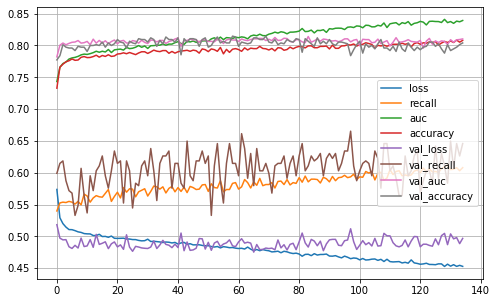

In [18]:
pd.DataFrame(nnIncMod.history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0.1,0.2)
plt.show()

In [ ]:
#dump(nnIncMod, 'NN2.joblib')

NameError: name 'dump' is not defined

In [ ]:
#Parameters
dim, batch = len(X_acc[0]), len(XAcc_train)//100

#IncomeInvestment model
nnIncMod.add(Dense(units=512, activation='relu', input_dim=dim))

#AccumulationInvestment model
nnAccMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnAccMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnAccMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[keras.metrics.RecallAtPrecision(), 'accuracy', keras.metrics.AUC()])
nnAccMod.fit(XAcc_train, Acc_train, batch_size=batch, epochs=1000, verbose=1, use_multiprocessing=True, validation_data=(XAcc_test, Acc_test))

In [ ]:
#Save the models
#dump(nnIncMod, 'NN_Inc.joblib')
#dump(nnAccMod, 'NN_Acc.joblib')

In [ ]:
#KNN
k = 3
knnIncMod, knnAccMod = KNN(n_neighbors=k, metric='euclidean'), KNN(n_neighbors=k, metric='euclidean')
knnIncMod.fit(X_train, Inc_train)
knnAccMod.fit(X_train, Acc_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Remark
For the logistic regression, we can also use other function for the Lasso and Ridge model (ex: RidgeClassifierCV,...) but we choose to not do it.

### Result of the model

Lets see how the model perform the validation set. 

In [19]:


# IncomeInvesstisment prediction
predLogInc = logIncMod.predict(XInc_test)
#predKnn = ncaPipeInc.predict(G_val)
#predPerceptronInc = prcptIncMod.predict(X_val)
predRFInc = rfModInc.predict(XInc_test)
predNnInc = nnIncMod.predict(XInc_test)
#predKnnInc = knnIncMod.predict(X_val)

# AccumuulentInvt prediction
predLogAcc = logAccMod.predict(XAcc_test)
#predPerceptronAcc = prcptAccMod.predict(X_val)
predRFAcc = rfModAcc.predict(XAcc_test)
#predNnAcc = nnAccMod.predict(X_val)
#predKnnAcc = knnAccMod.predict(X_val)

In [20]:
from sklearn.metrics import confusion_matrix

def valueModel(model, isInc=1):
    if isInc:
        print("Accuracy mean for train : ", model.score(XInc_test, Inc_test), " Accuracy mean for validation = ", model.score(XInc_train, Inc_train))
    else:
        print("Accuracy : ", model.score(XAcc_test, Acc_test), " Score = ", model.score(XAcc_train, Acc_train))

def confusionMat(prediction, isInc=1, plot=False):
    if isInc:
        cm = confusion_matrix(Inc_test, prediction)
    else:
        cm = confusion_matrix(Acc_test, prediction)
    if not plot: print(cm)
    if plot:
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0] 
    TP = cm[1][1]
    TPR = TP/(TP+FN) ; P = TP/(TP+FP) 
    TNR = (TN/(TN+FP)) ; F1 = (2*P*TPR)/(P+TPR)
    acc = (TP+TN)/(TP+TN+FP+FN)
    print("Measures:")
    print(f'Sensitivity = {TPR:2.2%} ;  Specificity = {TNR:2.2%} ; Precision = {P:2.2%} ; F1 score = {F1:2.2%} ; Accuracy = {acc:2.2%}')
    print()

Logistic model for Inc : 
Measures:
Sensitivity = 64.20% ;  Specificity = 88.24% ; Precision = 73.99% ; F1 score = 68.75% ; Accuracy = 80.00%



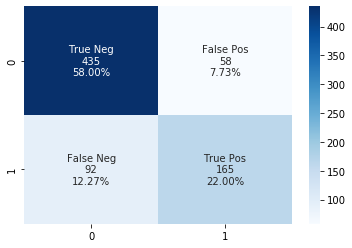

In [21]:
#Logistic model
print("Logistic model for Inc : ")
confusionMat(predLogInc, plot=True)

Logistic model for Acc : 
Measures:
Sensitivity = 69.77% ;  Specificity = 57.58% ; Precision = 63.68% ; F1 score = 66.58% ; Accuracy = 63.87%



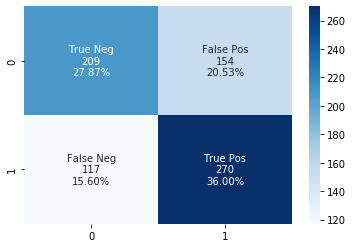

In [22]:
print("Logistic model for Acc : ")
confusionMat(predLogAcc, 0, True)

For the logistic models, the result is not bad especially for the IncomeInvestment model. We can calibrate the parameters for see if we can significatvly improve the models.

In [ ]:
#Perceptron
print("Perceptron model for Inc : ")
confusionMat(predPerceptronInc)

print("Perceptron model for Acc : ")
confusionMat(predPerceptronAcc, 0)

Perceptron model for Inc : 
[[488 170]
 [179 163]]
Measures:
Sensitivity = 47.66% ;  Specificity = 74.16% ; Precision = 48.95% ; F1 score = 48.30% ; Accuracy = 65.10%

Perceptron model for Acc : 
[[204 287]
 [158 351]]
Measures:
Sensitivity = 68.96% ;  Specificity = 41.55% ; Precision = 55.02% ; F1 score = 61.20% ; Accuracy = 55.50%



The results are very bad for the perceptron as expected. We forgot this model.

RF model for Inc : 
Measures:
Sensitivity = 63.81% ;  Specificity = 92.90% ; Precision = 82.41% ; F1 score = 71.93% ; Accuracy = 82.93%



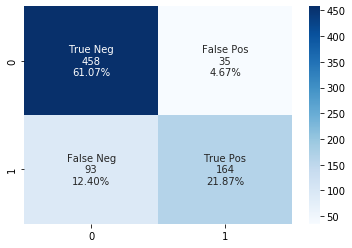

In [23]:
#Random Forest model
print("RF model for Inc : ")
confusionMat(predRFInc, plot=True)

RF model for Acc : 
Measures:
Sensitivity = 75.71% ;  Specificity = 85.67% ; Precision = 84.93% ; F1 score = 80.05% ; Accuracy = 80.53%



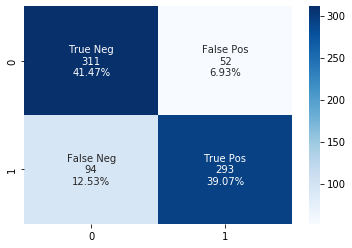

In [24]:
print("RF model for Acc : ")
confusionMat(predRFAcc, 0, True)

The results of the models are very good. The precision and accuracy are very hight. We can try to improve the models via the hyperparameters.

NN model for Inc
Measures:
Sensitivity = 64.59% ;  Specificity = 88.64% ; Precision = 74.77% ; F1 score = 69.31% ; Accuracy = 80.40%



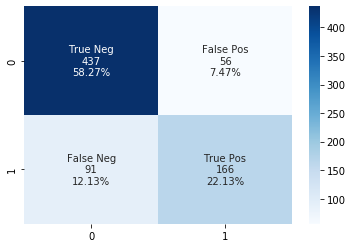

In [25]:
#Neural Networks model
ipre = (predNnInc > 0.5).astype(int)
print("NN model for Inc")
confusionMat(ipre, plot=True)

NN model for Acc
Measures:
Sensitivity = 70.13% ;  Specificity = 86.77% ; Precision = 84.76% ; F1 score = 76.76% ; Accuracy = 78.26%



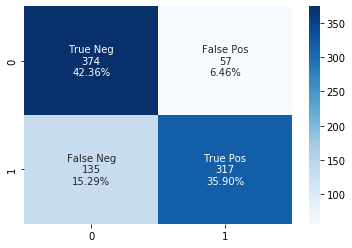

In [ ]:
apre = (predNnAcc > 0.45).astype(int)
print("NN model for Acc")
confusionMat(apre, isInc=0, plot=True)

Neural Networks model is fine for the IncomeInvestment model but for the AccumulationInvestment, is bad. We didn't exepct that so we can try to improve it. 

In [ ]:
#K-Nearest Neigthbhor
print("KNN model for Inc")
confusionMat(predKnnInc)
print(nnIncMod.evaluate(X_val, Inc_val))

print("KNN model for Acc")
confusionMat(predKnnAcc, 0)
print(nnAccMod.evaluate(X_val, Acc_val))

KNN model for Inc
[[526 132]
 [152 190]]
Measures:
Sensitivity = 55.56% ;  Specificity = 79.94% ; Precision = 59.01% ; F1 score = 57.23% ; Accuracy = 71.60%

32/32 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.8000
[0.5437507033348083, 0.800000011920929]
KNN model for Acc
[[318 173]
 [169 340]]
Measures:
Sensitivity = 66.80% ;  Specificity = 64.77% ; Precision = 66.28% ; F1 score = 66.54% ; Accuracy = 65.80%

32/32 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.8010
[0.49594631791114807, 0.8009999990463257]


For the end, the KNN model is not bad, we can compare it to the logistic models. But we choose to not continue with this model because we think this algo is not pertinent for our prediction.

## Model Selection and explanations

In [26]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

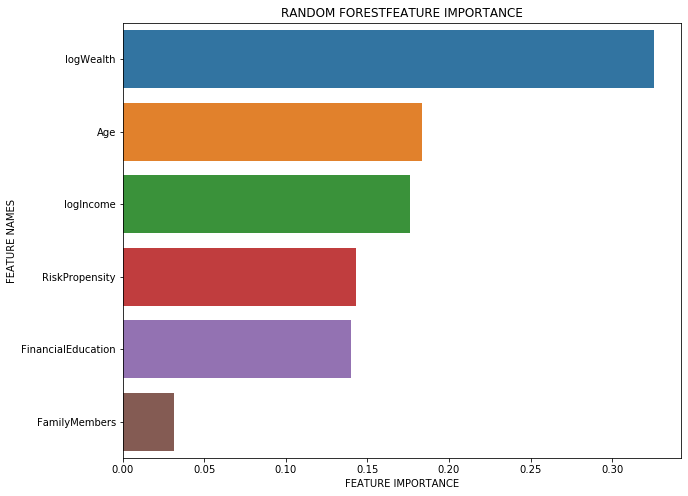

In [28]:
c = ["Age", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]
plot_feature_importance(rfModInc.feature_importances_, c,'RANDOM FOREST')

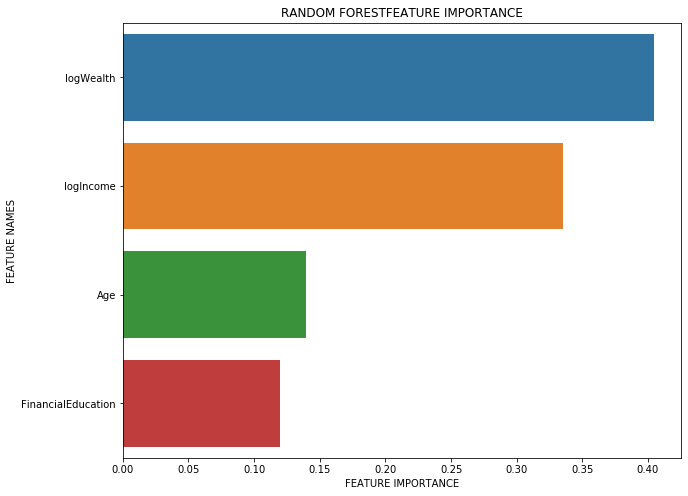

In [29]:
c = ["Age", "FinancialEducation", "logIncome", "logWealth"]
plot_feature_importance(rfModAcc.feature_importances_, c,'RANDOM FOREST')